In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. chia train, val, test (tỉ lệ 70/15/15)
target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)


# Tạo feature engineering
column_lag = ['temp','tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']

train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
(2562, 258)


In [37]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 257), (2562,)), Val: ((549, 257), (549,)), Test: ((549, 257), (549,))


In [15]:
# không để drop highly correlated ở preprocessing nữa, chuyển sang ở feature selection
from src import feature_selection as fs
dropHighCorr = fs.DropHighlyCorrelated()
dropHighCorr.fit(X_train)
X_train = dropHighCorr.transform(X_train)
X_val = dropHighCorr.transform(X_val)
X_test = dropHighCorr.transform(X_test)


In [ ]:
fs_pipeline_RF = pl.build_RF_featture_engineering_pipeline()
fs_pipeline_ET = pl.build_ExTree_featture_engineering_pipeline()
fs_pipeline_GB = pl.build_GB_featture_engineering_pipeline()

: 

In [21]:
# RF importance
# fit trên train
X_train = fs_pipeline_RF.fit_transform(X_train, y_train)

# transform 
X_train = fs_pipeline_RF.transform(X_train)
X_val = fs_pipeline_RF.transform(X_val)
X_test = fs_pipeline_RF.transform(X_test)

In [22]:
X_train.columns

Index(['temp_lag_1', 'feelslike_lag_1', 'pressure_temp_index_lag_1',
       'feelslikemin_lag_1', 'windspeed_lag_1', 'windgust_lag_1',
       'sunrise_lag_1', 'winddir_lag_1', 'solar_temp_index_lag_1',
       'temp_roll_mean_14', 'wind_variability_lag_1', 'dew_spread_lag_1',
       'tempmax_lag_1', 'temp_roll_mean_7', 'feelslikemax_lag_1',
       'tempmax_roll_mean_14', 'dew_lag_1', 'wind_temp_index_lag_1',
       'tempmin_roll_mean_14', 'pressure_temp_index_roll_mean_14',
       'day_length_lag_1', 'solarradiation_roll_std_14',
       'sealevelpressure_lag_1', 'sealevelpressure_roll_mean_14',
       'sealevelpressure_roll_std_7', 'humidity_lag_1', 'dew_roll_mean_14',
       'windgust_roll_mean_3', 'sunset_lag_1', 'precip_lag_1'],
      dtype='object')

In [32]:
# Extree importance
# fit trên train
fs_pipeline_ET.fit(X_train, y_train)

# transform 
X_train = fs_pipeline_ET.transform(X_train)
X_val = fs_pipeline_ET.transform(X_val)
X_test = fs_pipeline_ET.transform(X_test)

In [47]:
# chưa có feature selection
# 1. RF
## Default
# a. Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
# b. Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}

## Best parameter
# Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
# Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}


# 2. Extra Tree
## Default
# Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
# Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}

## Best parameter
# Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
# Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}

# 3. GB
## Default
# Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
# Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}

## Best parameter
# Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
# Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}
Task.current_task().close()

### Random Forest

In [ ]:
# ! pip install plotly
# === 1️ Khởi tạo Task (1 study = 1 Task) ===
# Khởi tạo task mới cho mỗi lần experiemt/ study bằng Task.create ...
# Hoặc nếu muốn tiếp tục với task cũ thì pass task id vào Task.get_task ...

# mấy đứa tự tạo task mới cũng được, không thì cop id trong clearml
# Nhớ đổi tên instance đi nhá, vd như task_1, logger_1
Task.current_task().close()
task = Task.get_task(task_id="7b83a27c498a4297a20d937179948683")
logger = task.get_logger()

# Tạo task mới trong project Temperature Forecasting
# task = Task.init(
#     project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
#     task_name="RF Optuna Tuning", # tên task mới
#     task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
# )

# print("✅ Task created successfully!")
# print("Task ID:", task.id)


███████████████████████████████ 100% | 24.99/24.99 MB [02:41<00:00,  6.47s/MB]: 


In [24]:
## A. default hyper parameter
# 1. fit 
model1 = RandomForestRegressor(n_estimators = 100, min_samples_split=2, min_samples_leaf=1,min_impurity_decrease=0, 
                               max_depth= 7, max_features= None, bootstrap= False, oob_score= False, 
                               max_leaf_nodes= None, max_samples= None, random_state= 42, n_jobs= -1
                               )
model1.fit(X_train, y_train) 

# 2. predict
y_pred_val = model1.predict(X_val) 
y_pred_test = model1.predict(X_test)

In [11]:
# Lấy feature importance
importances = model1.feature_importances_

# Tạo DataFrame hiển thị
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#print(feat_importance)

Text(0.5, 0, 'Importance')

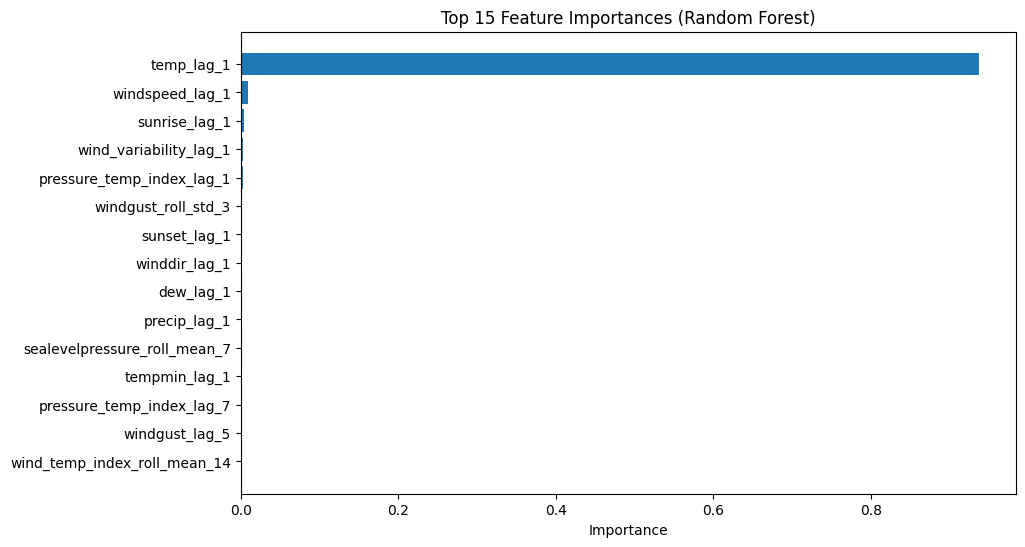

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'][:15], feat_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
#plt.show()


In [13]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
default_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", default_val_metrics)

# 4. Evaluate on test
default_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", default_test_metrics)

# 5. Save model 
model_path = r'models/RF_model.pkl' 
joblib.dump(model1, model_path)
print(f"RandomForest model saved to {model_path}")

# 6 Log lên ClearML
logger.report_scalar("Default Metrics", "RMSE_val", default_val_metrics["RMSE"], iteration=0)
logger.report_scalar("Default Metrics", "R2_val", default_val_metrics["R2"], iteration=0)
logger.report_scalar("Default Metrics", "MAPE_val", default_val_metrics["MAPE"], iteration=0)
logger.report_scalar("Default Metrics", "RMSE_test", default_test_metrics["RMSE"], iteration=0)
logger.report_scalar("Default Metrics", "R2_test", default_test_metrics["R2"], iteration=0)
logger.report_scalar("Default Metrics", "MAPE_test", default_test_metrics["MAPE"], iteration=0)


task.upload_artifact("Default Metrics", {
    "Validation": default_val_metrics,
    "Test": default_test_metrics
})


Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}
RandomForest model saved to models/RF_model.pkl


True

In [14]:
## B hyper parameter tuning
# === 1 Định nghĩa objective của optuna ===
def objective(trial):
    # Hyperparameter space
    params = {
    'n_estimators' : trial.suggest_int('n_estimators', 400, 1000),
    'max_depth' : trial.suggest_int('max_depth', 15, 35),
    'min_samples_split' : trial.suggest_int('min_samples_split', 5, 20),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 3, 8),
    'min_impurity_decrease' : trial.suggest_float('min_impurity_decrease', 0.001, 0.5),
    'max_features' : trial.suggest_categorical('max_features', ['sqrt']),
    'bootstrap' : False,
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 400, 700),
    'random_state' : 42, 
    'n_jobs' : -1 
    }

    # Time series CV
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        
        # Model
        model = RandomForestRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)
        rmse_scores.append(metrics['RMSE'])
    
    mean_rmse = np.mean(rmse_scores)

    # === 2 Log thông tin của trial lên ClearML ===
    # (a) Log RMSE cho mỗi trial
    logger.report_scalar(title = 'Optuna Tuning', series = 'Trial RMSE', value = mean_rmse, iteration = trial.number)

    # (b) Log toàn bộ tham số của trial (bảng tóm tắt)
    params_table = pd.DataFrame([params])
    logger.report_table(title=f"Trial {trial.number} Parameters", series="params", iteration=trial.number, table_plot=params_table)

    # Trả về RMSE trung bình của các cv để Optuna minimize
    return mean_rmse


In [15]:
# === 3 Chạy Optuna study ===
study = optuna.create_study(direction='minimize', sampler=sampler)  # minimize RMSE
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-10-21 03:59:58,940] A new study created in memory with name: no-name-b0ac1bec-9b73-4ea5-bfc5-ee16a8cc0d46
[I 2025-10-21 04:00:14,491] Trial 0 finished with value: 1.7509401082865224 and parameters: {'n_estimators': 625, 'max_depth': 34, 'min_samples_split': 16, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.07885330158077582, 'max_features': 'sqrt', 'max_leaf_nodes': 446}. Best is trial 0 with value: 1.7509401082865224.
[I 2025-10-21 04:00:28,720] Trial 1 finished with value: 1.6277715374624464 and parameters: {'n_estimators': 434, 'max_depth': 33, 'min_samples_split': 14, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.011271662653605422, 'max_features': 'sqrt', 'max_leaf_nodes': 691}. Best is trial 1 with value: 1.6277715374624464.
[I 2025-10-21 04:00:48,479] Trial 2 finished with value: 1.8434452458104276 and parameters: {'n_estimators': 900, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.1528168792368093, 'max_features': 'sqr

Best parameters: {'n_estimators': 910, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.003501511120214604, 'max_features': 'sqrt', 'max_leaf_nodes': 467}
Best RMSE: 1.6097896822825948


In [16]:
# === 4 Log kết quả tổng hợp ===
task.upload_artifact("Best Parameters", study.best_trial.params)

# Fit lại mô hình với best params
best_model = RandomForestRegressor(**study.best_trial.params)
best_model.fit(X_train, y_train)

# Predict
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Evaluate on validation
best_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", best_val_metrics)

# Evaluate on test
best_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", best_test_metrics)


# 6 Log lên ClearML
logger.report_scalar("Best Metrics", "RMSE_val", best_val_metrics["RMSE"], iteration=0)
logger.report_scalar("Best Metrics", "R2_val", best_val_metrics["R2"], iteration=0)
logger.report_scalar("Best Metrics", "MAPE_val", best_val_metrics["MAPE"], iteration=0)
logger.report_scalar("Best Metrics", "RMSE_test", best_test_metrics["RMSE"], iteration=0)
logger.report_scalar("Best Metrics", "R2_test", best_test_metrics["R2"], iteration=0)
logger.report_scalar("Best Metrics", "MAPE_test", best_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task.upload_artifact("Best Metrics", {
    "Validation": best_val_metrics,
    "Test": best_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_RF_model.pkl' 
joblib.dump(best_model, model_path)
print(f"RandomForest model saved to {model_path}")
task.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}
RandomForest model saved to models/Tuning_RF_model.pkl


True

In [17]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig,
    iteration=len(study.trials)
)
plt.close(fig)


In [38]:

# === 7️ Kết thúc Task ===
task.close()

In [20]:
vis.plot_optimization_history(study)


In [21]:
vis.plot_parallel_coordinate(study)

In [22]:
vis.plot_slice(study=study)

In [23]:
vis.plot_param_importances(study=study)

### Extra Tree

In [ ]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting
Task.current_task().close()
# task = Task.init(
#     project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
#     task_name="ExtraTree Optuna Tuning", # tên task mới
#     task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
# )

# print("✅ Task created successfully!")
# print("Task ID:", task.id)

ClearML Task: created new task id=20da5909b4454c7baafbb9ecb538dd94
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/20da5909b4454c7baafbb9ecb538dd94/output/log
✅ Task created successfully!
Task ID: 20da5909b4454c7baafbb9ecb538dd94


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2025-10-21 07:19:33,915 - clearml.storage - INFO - Uploading: 21.70MB from c:/Users/Admin/Documents/ML/group1/models/Tuning_ExTree_model.pkl


████████████████████████████████ 100% | 21.70/21.7 MB [01:54<00:00,  5.27s/MB]: 


In [9]:
task_extra = Task.get_task(task_id="20da5909b4454c7baafbb9ecb538dd94")
logger_extra = task_extra.get_logger()

In [34]:
## A. default hyper parameter
# 1. fit 
model_ex = ExtraTreesRegressor(
    n_estimators = 100,          # số cây (default)
    criterion = 'squared_error', # hàm loss mặc định
    max_depth = 7,               # bạn đặt theo baseline RF
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_impurity_decrease = 0.0,
    max_features = None,         # xét tất cả features
    max_leaf_nodes = None,
    bootstrap = False,           # ExtraTrees mặc định là False
    oob_score = False,           # không dùng out-of-bag
    max_samples = None,
    random_state = 42,
    n_jobs = -1
)
model_ex.fit(X_train, y_train) 

# 2. predict
y_pred_val = model_ex.predict(X_val) 
y_pred_test = model_ex.predict(X_test)

In [35]:
# 3. Evaluate on validation
defEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defEx_val_metrics)

# 4. Evaluate on test
defEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defEx_test_metrics)

Validation metrics: {'RMSE': 1.5601582607522162, 'R2': 0.9084776815242552, 'MAPE': 5.242943797499387}
Test metrics: {'RMSE': 1.3974525388138206, 'R2': 0.9097687609474473, 'MAPE': 4.450040592901364}


In [45]:
# Lấy feature importance
importances_extra = model_ex.feature_importances_

# Tạo DataFrame hiển thị
feat_importance_extra = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_extra
}).sort_values(by='Importance', ascending=False)

#print(feat_importance_extra)

Text(0.5, 0, 'Importance')

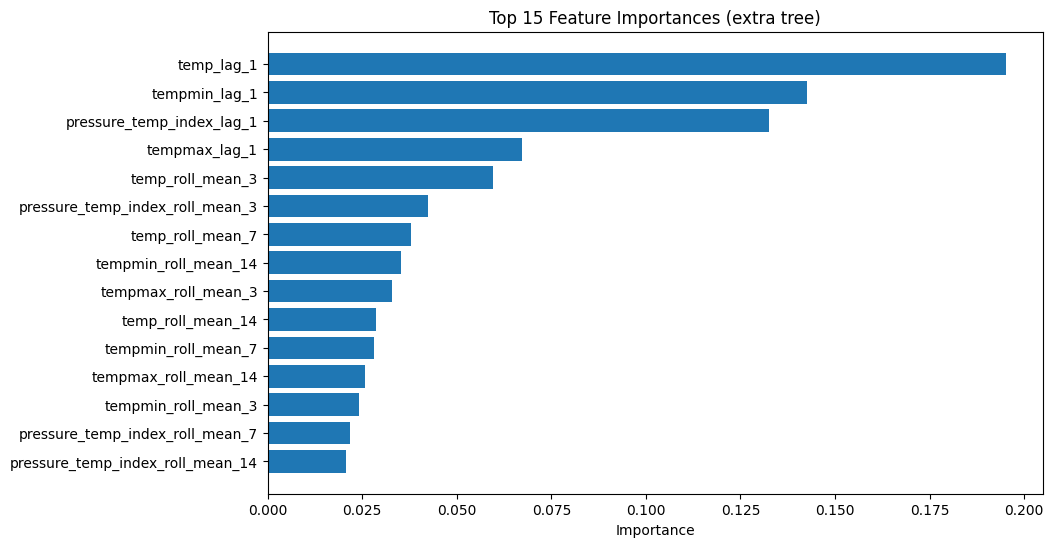

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_extra['Feature'][:15], feat_importance_extra['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (extra tree)")
plt.xlabel("Importance")
#plt.show()

In [17]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
defEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defEx_val_metrics)

# 4. Evaluate on test
defEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defEx_test_metrics)

# 5. Save model 
model_path = r'models/ExTree_model.pkl' 
joblib.dump(model_ex, model_path)
print(f"ExtraTree model saved to {model_path}")

# 6 Log lên ClearML
logger_extra.report_scalar("Default Metrics", "RMSE_val", defEx_val_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "R2_val", defEx_val_metrics["R2"], iteration=0)
logger_extra.report_scalar("Default Metrics", "MAPE_val", defEx_val_metrics["MAPE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "RMSE_test", defEx_test_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Default Metrics", "R2_test", defEx_test_metrics["R2"], iteration=0)
logger_extra.report_scalar("Default Metrics", "MAPE_test", defEx_test_metrics["MAPE"], iteration=0)


task_extra.upload_artifact("Default Metrics", {
    "Validation": defEx_val_metrics,
    "Test": defEx_test_metrics
})


Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}
ExtraTree model saved to models/ExTree_model.pkl


True

In [18]:
## B. Hyperparameter tuning cho ExtraTrees
def objective(trial):
    # === 1. Định nghĩa không gian hyperparameter ===
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),       # default = 100
        'max_depth': trial.suggest_int('max_depth', 5, 50),                # default = None
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),# default = 2
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),   # default = 1
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.3), # default = 0
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': False, # default = False
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 1000),   # default = None
        'random_state': 42,
        'n_jobs': -1
    }

    # === 2. TimeSeriesSplit CV ===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # === 3. Train model ===
        model = ExtraTreesRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)  # bạn có hàm evaluate riêng rồi
        rmse_scores.append(metrics['RMSE'])

    mean_rmse = np.mean(rmse_scores)

    # === 4. Log kết quả lên ClearML ===
    # (a) Log giá trị RMSE của trial
    logger_extra.report_scalar(
        title='Optuna Tuning - ExtraTrees',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    # (b) Log bảng thông số
    params_table = pd.DataFrame([params])
    logger_extra.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    # === 5. Trả về giá trị cần minimize (RMSE) ===
    return mean_rmse


In [19]:
# === 3. Chạy Optuna study cho ExtraTrees ===
study_ex = optuna.create_study(
    direction='minimize',   # mục tiêu: giảm RMSE
    sampler=sampler
)

# Tiến hành tối ưu
study_ex.optimize(objective, n_trials=50, show_progress_bar=True)

# === 4. In kết quả tốt nhất ===
print("Best parameters:", study_ex.best_trial.params)
print("Best RMSE:", study_ex.best_value)


[I 2025-10-21 05:58:06,982] A new study created in memory with name: no-name-b69554ff-c087-4fa8-bf8d-bb591f9731b2
Best trial: 0. Best value: 1.59908:   2%|▏         | 1/50 [00:12<10:27, 12.80s/it]

[I 2025-10-21 05:58:19,782] Trial 0 finished with value: 1.5990817073040768 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.04680559213273095, 'max_features': None, 'max_leaf_nodes': 641}. Best is trial 0 with value: 1.5990817073040768.


Best trial: 0. Best value: 1.59908:   4%|▍         | 2/50 [00:32<13:17, 16.61s/it]

[I 2025-10-21 05:58:39,064] Trial 1 finished with value: 1.6325372268308342 and parameters: {'n_estimators': 737, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.06370173320348284, 'max_features': None, 'max_leaf_nodes': 572}. Best is trial 0 with value: 1.5990817073040768.


Best trial: 0. Best value: 1.59908:   6%|▌         | 3/50 [00:43<11:13, 14.32s/it]

[I 2025-10-21 05:58:50,660] Trial 2 finished with value: 1.6494402309519742 and parameters: {'n_estimators': 489, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.08764339456056544, 'max_features': None, 'max_leaf_nodes': 279}. Best is trial 0 with value: 1.5990817073040768.


Best trial: 0. Best value: 1.59908:   8%|▊         | 4/50 [00:58<11:16, 14.70s/it]

[I 2025-10-21 05:59:05,952] Trial 3 finished with value: 1.607132994492444 and parameters: {'n_estimators': 563, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.051157237106187456, 'max_features': None, 'max_leaf_nodes': 828}. Best is trial 0 with value: 1.5990817073040768.


Best trial: 4. Best value: 1.58341:  10%|█         | 5/50 [01:09<09:58, 13.29s/it]

[I 2025-10-21 05:59:16,750] Trial 4 finished with value: 1.5834131688297148 and parameters: {'n_estimators': 374, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.036611470453433645, 'max_features': None, 'max_leaf_nodes': 333}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  12%|█▏        | 6/50 [01:16<08:13, 11.21s/it]

[I 2025-10-21 05:59:23,899] Trial 5 finished with value: 1.8855972277849644 and parameters: {'n_estimators': 696, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.05545633665765811, 'max_features': 'sqrt', 'max_leaf_nodes': 906}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  14%|█▍        | 7/50 [01:23<07:03,  9.85s/it]

[I 2025-10-21 05:59:30,968] Trial 6 finished with value: 1.8845864367790832 and parameters: {'n_estimators': 638, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01356818667316142, 'max_features': 'log2', 'max_leaf_nodes': 846}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  16%|█▌        | 8/50 [01:28<05:44,  8.21s/it]

[I 2025-10-21 05:59:35,640] Trial 7 finished with value: 2.288769514827592 and parameters: {'n_estimators': 421, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.2406590942262119, 'max_features': 'log2', 'max_leaf_nodes': 279}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  18%|█▊        | 9/50 [01:30<04:11,  6.13s/it]

[I 2025-10-21 05:59:37,222] Trial 8 finished with value: 2.309883572699083 and parameters: {'n_estimators': 104, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.2313811040057837, 'max_features': 'log2', 'max_leaf_nodes': 877}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  20%|██        | 10/50 [01:44<05:48,  8.70s/it]

[I 2025-10-21 05:59:51,686] Trial 9 finished with value: 1.6615481646203456 and parameters: {'n_estimators': 661, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.09755499660802411, 'max_features': None, 'max_leaf_nodes': 525}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 4. Best value: 1.58341:  22%|██▏       | 11/50 [01:54<05:47,  8.92s/it]

[I 2025-10-21 06:00:01,079] Trial 10 finished with value: 2.066418271011817 and parameters: {'n_estimators': 951, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.16085657660932784, 'max_features': 'sqrt', 'max_leaf_nodes': 114}. Best is trial 4 with value: 1.5834131688297148.


Best trial: 11. Best value: 1.52375:  24%|██▍       | 12/50 [02:10<07:01, 11.09s/it]

[I 2025-10-21 06:00:17,129] Trial 11 finished with value: 1.523754140428553 and parameters: {'n_estimators': 294, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0027683007133353157, 'max_features': None, 'max_leaf_nodes': 582}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  26%|██▌       | 13/50 [02:23<07:17, 11.83s/it]

[I 2025-10-21 06:00:30,670] Trial 12 finished with value: 1.526351654772212 and parameters: {'n_estimators': 227, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0023922249698360085, 'max_features': None, 'max_leaf_nodes': 396}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  28%|██▊       | 14/50 [02:28<05:49,  9.72s/it]

[I 2025-10-21 06:00:35,514] Trial 13 finished with value: 1.7005436953317747 and parameters: {'n_estimators': 230, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.14228480479966227, 'max_features': None, 'max_leaf_nodes': 431}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  30%|███       | 15/50 [02:40<06:06, 10.47s/it]

[I 2025-10-21 06:00:47,713] Trial 14 finished with value: 1.5314560188736785 and parameters: {'n_estimators': 264, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.007664848443163036, 'max_features': None, 'max_leaf_nodes': 720}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  32%|███▏      | 16/50 [02:42<04:23,  7.76s/it]

[I 2025-10-21 06:00:49,182] Trial 15 finished with value: 2.1612532715832486 and parameters: {'n_estimators': 126, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.29880509680836403, 'max_features': 'sqrt', 'max_leaf_nodes': 441}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  34%|███▍      | 17/50 [02:48<04:00,  7.28s/it]

[I 2025-10-21 06:00:55,344] Trial 16 finished with value: 1.690876431413472 and parameters: {'n_estimators': 293, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.12847659481075646, 'max_features': None, 'max_leaf_nodes': 696}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  36%|███▌      | 18/50 [02:54<03:45,  7.05s/it]

[I 2025-10-21 06:01:01,847] Trial 17 finished with value: 1.7272734189728396 and parameters: {'n_estimators': 331, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.18496255345188253, 'max_features': None, 'max_leaf_nodes': 118}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  38%|███▊      | 19/50 [02:57<02:59,  5.79s/it]

[I 2025-10-21 06:01:04,698] Trial 18 finished with value: 1.705927232683969 and parameters: {'n_estimators': 227, 'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.00014212030256912592, 'max_features': 'sqrt', 'max_leaf_nodes': 422}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  40%|████      | 20/50 [02:59<02:20,  4.67s/it]

[I 2025-10-21 06:01:06,776] Trial 19 finished with value: 2.146526693055383 and parameters: {'n_estimators': 188, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.09542294520450934, 'max_features': 'log2', 'max_leaf_nodes': 556}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  42%|████▏     | 21/50 [03:17<04:05,  8.47s/it]

[I 2025-10-21 06:01:24,089] Trial 20 finished with value: 1.6752966616141318 and parameters: {'n_estimators': 845, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.11309879122991345, 'max_features': None, 'max_leaf_nodes': 212}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  44%|████▍     | 22/50 [03:27<04:11,  8.98s/it]

[I 2025-10-21 06:01:34,254] Trial 21 finished with value: 1.5497236881390382 and parameters: {'n_estimators': 294, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.017434249220333264, 'max_features': None, 'max_leaf_nodes': 746}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  46%|████▌     | 23/50 [03:34<03:46,  8.38s/it]

[I 2025-10-21 06:01:41,252] Trial 22 finished with value: 1.5679621260914618 and parameters: {'n_estimators': 213, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.02700028414056692, 'max_features': None, 'max_leaf_nodes': 744}. Best is trial 11 with value: 1.523754140428553.


Best trial: 11. Best value: 1.52375:  48%|████▊     | 24/50 [03:42<03:34,  8.23s/it]

[I 2025-10-21 06:01:49,140] Trial 23 finished with value: 1.6331311890940838 and parameters: {'n_estimators': 326, 'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.07202354786212121, 'max_features': None, 'max_leaf_nodes': 984}. Best is trial 11 with value: 1.523754140428553.


Best trial: 24. Best value: 1.5237:  50%|█████     | 25/50 [04:11<06:07, 14.69s/it] 

[I 2025-10-21 06:02:18,878] Trial 24 finished with value: 1.5236951203372882 and parameters: {'n_estimators': 502, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0038686233519529584, 'max_features': None, 'max_leaf_nodes': 627}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  52%|█████▏    | 26/50 [04:28<06:06, 15.28s/it]

[I 2025-10-21 06:02:35,560] Trial 25 finished with value: 1.573771022600014 and parameters: {'n_estimators': 554, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.029916974116560024, 'max_features': None, 'max_leaf_nodes': 631}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  54%|█████▍    | 27/50 [05:01<07:49, 20.43s/it]

[I 2025-10-21 06:03:07,992] Trial 26 finished with value: 1.5240869017052332 and parameters: {'n_estimators': 473, 'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0031038109060421985, 'max_features': None, 'max_leaf_nodes': 494}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  56%|█████▌    | 28/50 [05:12<06:31, 17.77s/it]

[I 2025-10-21 06:03:19,570] Trial 27 finished with value: 1.6343713302975338 and parameters: {'n_estimators': 485, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.07218552274866853, 'max_features': None, 'max_leaf_nodes': 494}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  58%|█████▊    | 29/50 [05:19<05:01, 14.37s/it]

[I 2025-10-21 06:03:26,000] Trial 28 finished with value: 2.016142558798332 and parameters: {'n_estimators': 595, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.02926105771009733, 'max_features': 'log2', 'max_leaf_nodes': 625}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  60%|██████    | 30/50 [05:24<03:53, 11.68s/it]

[I 2025-10-21 06:03:31,400] Trial 29 finished with value: 1.8669228337578663 and parameters: {'n_estimators': 471, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.04512861932542525, 'max_features': 'sqrt', 'max_leaf_nodes': 594}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  62%|██████▏   | 31/50 [05:34<03:32, 11.18s/it]

[I 2025-10-21 06:03:41,398] Trial 30 finished with value: 1.7250402701084941 and parameters: {'n_estimators': 405, 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.18332931163087207, 'max_features': None, 'max_leaf_nodes': 492}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  64%|██████▍   | 32/50 [06:00<04:40, 15.60s/it]

[I 2025-10-21 06:04:07,338] Trial 31 finished with value: 1.5243202045894193 and parameters: {'n_estimators': 360, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0035070938131738045, 'max_features': None, 'max_leaf_nodes': 370}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 24. Best value: 1.5237:  66%|██████▌   | 33/50 [06:13<04:12, 14.84s/it]

[I 2025-10-21 06:04:20,403] Trial 32 finished with value: 1.58978464996247 and parameters: {'n_estimators': 380, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.040264089564674, 'max_features': None, 'max_leaf_nodes': 363}. Best is trial 24 with value: 1.5236951203372882.


Best trial: 33. Best value: 1.52172:  68%|██████▊   | 34/50 [06:52<05:54, 22.14s/it]

[I 2025-10-21 06:04:59,579] Trial 33 finished with value: 1.5217242861904132 and parameters: {'n_estimators': 489, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0020519908217961035, 'max_features': None, 'max_leaf_nodes': 676}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  70%|███████   | 35/50 [07:08<05:03, 20.21s/it]

[I 2025-10-21 06:05:15,272] Trial 34 finished with value: 1.6246351533308268 and parameters: {'n_estimators': 515, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.06413813880771567, 'max_features': None, 'max_leaf_nodes': 667}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  72%|███████▏  | 36/50 [07:41<05:36, 24.05s/it]

[I 2025-10-21 06:05:48,300] Trial 35 finished with value: 1.5571540698654773 and parameters: {'n_estimators': 788, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.01930036116309236, 'max_features': None, 'max_leaf_nodes': 589}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  74%|███████▍  | 37/50 [07:55<04:34, 21.10s/it]

[I 2025-10-21 06:06:02,520] Trial 36 finished with value: 1.6031305688237558 and parameters: {'n_estimators': 432, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.05003129065519235, 'max_features': None, 'max_leaf_nodes': 793}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  76%|███████▌  | 38/50 [08:13<04:01, 20.12s/it]

[I 2025-10-21 06:06:20,328] Trial 37 finished with value: 1.6409144035674994 and parameters: {'n_estimators': 612, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.07808373781433507, 'max_features': None, 'max_leaf_nodes': 488}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  78%|███████▊  | 39/50 [08:31<03:35, 19.61s/it]

[I 2025-10-21 06:06:38,758] Trial 38 finished with value: 1.5850790207362786 and parameters: {'n_estimators': 529, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.03699729901799936, 'max_features': None, 'max_leaf_nodes': 659}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  80%|████████  | 40/50 [08:37<02:34, 15.50s/it]

[I 2025-10-21 06:06:44,665] Trial 39 finished with value: 2.0685864377920056 and parameters: {'n_estimators': 457, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.05490674449743011, 'max_features': 'log2', 'max_leaf_nodes': 791}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  82%|████████▏ | 41/50 [09:11<03:07, 20.86s/it]

[I 2025-10-21 06:07:18,024] Trial 40 finished with value: 1.5521295835394642 and parameters: {'n_estimators': 687, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.018668982115223394, 'max_features': None, 'max_leaf_nodes': 534}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  84%|████████▍ | 42/50 [1:16:52<2:44:23, 1232.92s/it]

[I 2025-10-21 07:14:59,110] Trial 41 finished with value: 1.5391036820407078 and parameters: {'n_estimators': 371, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.012256154692135457, 'max_features': None, 'max_leaf_nodes': 309}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  86%|████████▌ | 43/50 [1:17:10<1:41:19, 868.44s/it] 

[I 2025-10-21 07:15:17,095] Trial 42 finished with value: 1.5236449274253738 and parameters: {'n_estimators': 353, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0021492550011880467, 'max_features': None, 'max_leaf_nodes': 224}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  88%|████████▊ | 44/50 [1:17:25<1:01:14, 612.39s/it]

[I 2025-10-21 07:15:32,014] Trial 43 finished with value: 1.56782226454884 and parameters: {'n_estimators': 510, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.02669407454485325, 'max_features': None, 'max_leaf_nodes': 223}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  90%|█████████ | 45/50 [1:17:52<36:24, 437.00s/it]  

[I 2025-10-21 07:15:59,780] Trial 44 finished with value: 1.521861090289064 and parameters: {'n_estimators': 441, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0009353793760996771, 'max_features': None, 'max_leaf_nodes': 598}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  92%|█████████▏| 46/50 [1:17:55<20:27, 306.75s/it]

[I 2025-10-21 07:16:02,616] Trial 45 finished with value: 1.874536335614383 and parameters: {'n_estimators': 405, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.050164425544144096, 'max_features': 'sqrt', 'max_leaf_nodes': 596}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  94%|█████████▍| 47/50 [1:18:13<10:59, 219.95s/it]

[I 2025-10-21 07:16:20,039] Trial 46 finished with value: 1.551271282660369 and parameters: {'n_estimators': 594, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.018047364829072723, 'max_features': None, 'max_leaf_nodes': 698}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  96%|█████████▌| 48/50 [1:18:22<05:13, 156.72s/it]

[I 2025-10-21 07:16:29,202] Trial 47 finished with value: 1.525383219474549 and parameters: {'n_estimators': 159, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0004386780234173042, 'max_features': None, 'max_leaf_nodes': 635}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172:  98%|█████████▊| 49/50 [1:18:24<01:50, 110.49s/it]

[I 2025-10-21 07:16:31,830] Trial 48 finished with value: 2.3040572523817158 and parameters: {'n_estimators': 282, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.24863876645200433, 'max_features': 'log2', 'max_leaf_nodes': 549}. Best is trial 33 with value: 1.5217242861904132.


Best trial: 33. Best value: 1.52172: 100%|██████████| 50/50 [1:18:32<00:00, 94.24s/it] 

[I 2025-10-21 07:16:39,219] Trial 49 finished with value: 1.5794466205800917 and parameters: {'n_estimators': 331, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.03478849914668711, 'max_features': None, 'max_leaf_nodes': 681}. Best is trial 33 with value: 1.5217242861904132.
Best parameters: {'n_estimators': 489, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0020519908217961035, 'max_features': None, 'max_leaf_nodes': 676}
Best RMSE: 1.5217242861904132


In [ ]:
# === 4 Log kết quả tổng hợp ===
task_extra.upload_artifact("Best Parameters", study_ex.best_trial.params)

# Fit lại mô hình với best params
best_model_ex = ExtraTreesRegressor(**study_ex.best_trial.params)
best_model_ex.fit(X_train, y_train)

# Predict
y_pred_val = best_model_ex.predict(X_val)
y_pred_test = best_model_ex.predict(X_test)

# Evaluate on validation
bestEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", bestEx_val_metrics)

# Evaluate on test
bestEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", bestEx_test_metrics)


# 6 Log lên ClearML
logger_extra.report_scalar("Best Metrics", "RMSE_val", bestEx_val_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "R2_val", bestEx_val_metrics["R2"], iteration=0)
logger_extra.report_scalar("Best Metrics", "MAPE_val", bestEx_val_metrics["MAPE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "RMSE_test", bestEx_test_metrics["RMSE"], iteration=0)
logger_extra.report_scalar("Best Metrics", "R2_test", bestEx_test_metrics["R2"], iteration=0)
logger_extra.report_scalar("Best Metrics", "MAPE_test", bestEx_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task_extra.upload_artifact("Best Metrics", {
    "Validation": bestEx_val_metrics,
    "Test": bestEx_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_ExTree_model.pkl' 
joblib.dump(best_model_ex, model_path)
print(f"RandomForest model saved to {model_path}")
task_extra.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}
RandomForest model saved to models/Tuning_ExTree_model.pkl


True

In [21]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig2 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_ex.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_extra.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig2,
    iteration=len(study_ex.trials)
)
plt.close(fig2)


In [22]:
task_extra.close()

In [23]:
vis.plot_parallel_coordinate(study_ex)

In [24]:
vis.plot_slice(study=study_ex)

In [25]:
vis.plot_param_importances(study=study_ex)

### Gradient Boosting 

In [ ]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting
Task.current_task().close()
# task = Task.init(
#     project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
#     task_name="RF Optuna Tuning", # tên task mới
#     task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
# )

# print("✅ Task created successfully!")
# print("Task ID:", task.id)

In [26]:
task_grad = Task.get_task(task_id="15f754d1ec5a4904b0a17d442ec88b57")
logger_grad = task.get_logger()

In [29]:
## A. default hyper parameter
# 1. fit 
model_grad = GradientBoostingRegressor(
    loss='squared_error', # Hàm mất mát, mặc định squared_error
    learning_rate=0.1,
    n_estimators=100,    # Số lượng cây boosting, mặc định 100
    subsample=1.0,      # Tỉ lệ mẫu dùng mỗi vòng (1.0 = full dataset)
    criterion='friedman_mse',   # Tiêu chí chia node, mặc định friedman_mse
    min_samples_split=2,     # Số mẫu tối thiểu trong leaf
    min_samples_leaf=1,  # Số mẫu tối thiểu trong leaf
    min_weight_fraction_leaf=0.0,   # Tỷ lệ trọng số tối thiểu trong leaf
    max_depth=3,    # Độ sâu tối đa của mỗi cây (default = 3)
    min_impurity_decrease=0.0,
    random_state=42,
    max_features=None,   # Số lượng feature xem xét khi chia, None = tất cả
    alpha=0.9,    # Dành cho loss='huber' hoặc 'quantile'
    max_leaf_nodes=None,     # Số leaf tối đa mỗi cây
    warm_start=False,   # để False khi tuning, Dùng để tiếp tục huấn luyện model cũ
    #validation_fraction= 0.1,   # ❌ tránh dùng để không leak
    n_iter_no_change=None,      # ❌ tránh auto validation split
    tol=1e-4,       # Ngưỡng dừng sớm cho early stopping
    ccp_alpha=0.0  # Complexity pruning, mặc định 0
)

model_grad.fit(X_train, y_train) 

# 2. predict
y_pred_val = model_grad.predict(X_val) 
y_pred_test = model_grad.predict(X_test)


In [30]:
# Lấy feature importance
importances_grad = model_grad.feature_importances_

# Tạo DataFrame hiển thị
feat_importance_grad = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_grad
}).sort_values(by='Importance', ascending=False)

print(feat_importance_grad)

                         Feature  Importance
2                     temp_lag_1    0.721221
1                  tempmin_lag_1    0.070129
30     pressure_temp_index_lag_1    0.050341
16                 sunrise_lag_1    0.036718
152         tempmin_roll_mean_14    0.023370
..                           ...         ...
121    pressure_temp_index_lag_3    0.000000
190  wind_temp_index_roll_mean_7    0.000000
189  wind_temp_index_roll_mean_3    0.000000
123    pressure_temp_index_lag_5    0.000000
126        wind_temp_index_lag_2    0.000000

[252 rows x 2 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


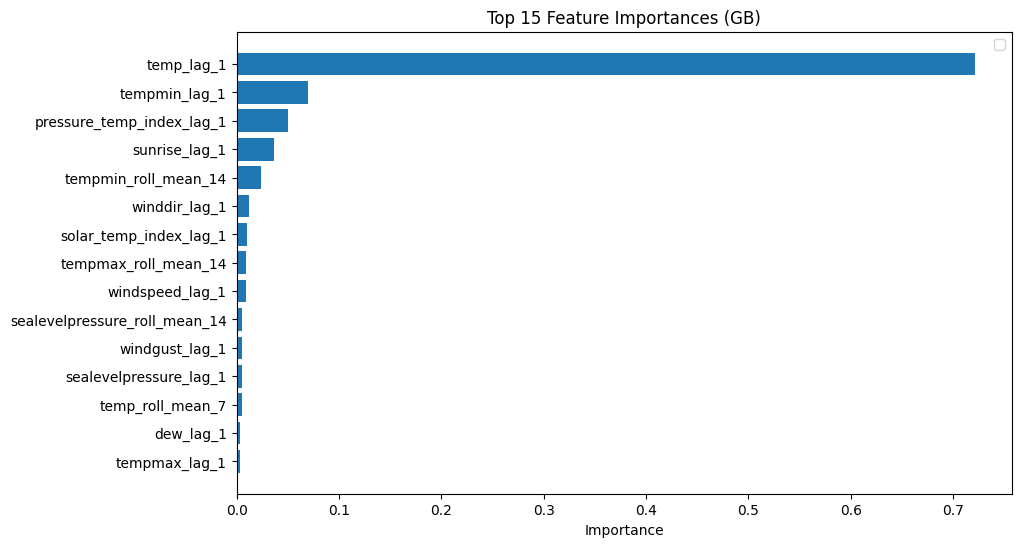

In [32]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_grad['Feature'][:15], feat_importance_grad['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (GB)")
plt.xlabel("Importance")
plt.show()

In [33]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
defGrad_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defGrad_val_metrics)

# 4. Evaluate on test
defGrad_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defGrad_test_metrics)

# 5. Save model 
model_path = r'models/GradBoosting_model.pkl' 
joblib.dump(model_grad, model_path)
print(f"ExtraTree model saved to {model_path}")

# 6 Log lên ClearML
logger_grad.report_scalar("Default Metrics", "RMSE_val", defGrad_val_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_val", defGrad_val_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_val", defGrad_val_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "RMSE_test", defGrad_test_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_test", defGrad_test_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_test", defGrad_test_metrics["MAPE"], iteration=0)


task_grad.upload_artifact("Default Metrics", {
    "Validation": defGrad_val_metrics,
    "Test": defGrad_test_metrics
})


Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}
ExtraTree model saved to models/GradBoosting_model.pkl


True

In [34]:
## B. Hyperparameter tuning cho Gradient Boosting
def objective(trial):
    # === 1. Định nghĩa không gian hyperparameter ===
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'huber']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),   # default = 0.1
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),       # default = 100
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),            # default = 1.0
        'criterion': 'friedman_mse',                                        # default
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # default = 2
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),    # default = 1
        'max_depth': trial.suggest_int('max_depth', 2, 7),                  # default = 3
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 500),     # default = None
        'alpha': trial.suggest_float('alpha', 0.85, 0.95),                  # chỉ dùng nếu loss='huber' hoặc 'quantile'
        'tol': 1e-4,
        'ccp_alpha': 0.0,
        'random_state': 42
        # ⚠️ Không dùng early stopping (n_iter_no_change, validation_fraction)
        # vì đây là time series → tránh leak
    }

    # === 2. TimeSeriesSplit CV ===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # === 3. Train model ===
        model = GradientBoostingRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)
        rmse_scores.append(metrics['RMSE'])

    mean_rmse = np.mean(rmse_scores)

    # === 4. Log kết quả lên ClearML ===
    # (a) Log RMSE cho mỗi trial
    logger_grad.report_scalar(
        title='Optuna Tuning - GradientBoosting',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    # (b) Log toàn bộ tham số của trial (bảng tóm tắt)
    params_table = pd.DataFrame([params])
    logger_grad.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    # === 5. Trả về RMSE trung bình của các fold để Optuna minimize ===
    return mean_rmse


In [35]:
# === 3. Chạy Optuna study cho ExtraTrees ===
study_grad = optuna.create_study(
    direction='minimize',   # mục tiêu: giảm RMSE
    sampler=sampler
)

# Tiến hành tối ưu
study_grad.optimize(objective, n_trials=50, show_progress_bar=True)

# === 4. In kết quả tốt nhất ===
print("Best parameters:", study_grad.best_trial.params)
print("Best RMSE:", study_grad.best_value)


[I 2025-10-21 08:28:57,232] A new study created in memory with name: no-name-b651856f-dcc4-4d0a-afba-9b9d7c02fb69
Best trial: 0. Best value: 1.62064:   2%|▏         | 1/50 [04:21<3:33:35, 261.54s/it]

[I 2025-10-21 08:33:18,780] Trial 0 finished with value: 1.6206408671335133 and parameters: {'loss': 'huber', 'learning_rate': 0.23062766409890026, 'n_estimators': 605, 'subsample': 0.9083868719818244, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.005083825348819038, 'max_features': None, 'max_leaf_nodes': 191, 'alpha': 0.9008570691164702}. Best is trial 0 with value: 1.6206408671335133.


Best trial: 0. Best value: 1.62064:   4%|▍         | 2/50 [07:34<2:56:52, 221.10s/it]

[I 2025-10-21 08:36:31,574] Trial 1 finished with value: 1.6252330109327642 and parameters: {'loss': 'squared_error', 'learning_rate': 0.1290110476803326, 'n_estimators': 780, 'subsample': 0.6915192661966489, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2, 'min_impurity_decrease': 0.18593953046851464, 'max_features': None, 'max_leaf_nodes': 412, 'alpha': 0.8686570058886035}. Best is trial 0 with value: 1.6206408671335133.


Best trial: 0. Best value: 1.62064:   6%|▌         | 3/50 [07:50<1:39:57, 127.61s/it]

[I 2025-10-21 08:36:47,923] Trial 2 finished with value: 1.7392028199912275 and parameters: {'loss': 'squared_error', 'learning_rate': 0.24415764499757814, 'n_estimators': 907, 'subsample': 0.7272013899887455, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.16360295318449863, 'max_features': 'sqrt', 'max_leaf_nodes': 238, 'alpha': 0.872210781047073}. Best is trial 0 with value: 1.6206408671335133.


Best trial: 0. Best value: 1.62064:   8%|▊         | 4/50 [07:59<1:01:47, 80.60s/it] 

[I 2025-10-21 08:36:56,458] Trial 3 finished with value: 1.845015311833657 and parameters: {'loss': 'huber', 'learning_rate': 0.28344381413463055, 'n_estimators': 391, 'subsample': 0.8075162486973464, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 7, 'min_impurity_decrease': 0.19248945898842226, 'max_features': 'log2', 'max_leaf_nodes': 178, 'alpha': 0.8536886947354533}. Best is trial 0 with value: 1.6206408671335133.


Best trial: 4. Best value: 1.54743:  10%|█         | 5/50 [11:57<1:42:59, 137.31s/it]

[I 2025-10-21 08:40:54,333] Trial 4 finished with value: 1.5474255782829527 and parameters: {'loss': 'squared_error', 'learning_rate': 0.02492883786249691, 'n_estimators': 351, 'subsample': 0.9633063543866615, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4, 'min_impurity_decrease': 0.19713009082212016, 'max_features': None, 'max_leaf_nodes': 157, 'alpha': 0.922821634861186}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  12%|█▏        | 6/50 [12:15<1:11:09, 97.02s/it] 

[I 2025-10-21 08:41:13,151] Trial 5 finished with value: 1.715748424366728 and parameters: {'loss': 'huber', 'learning_rate': 0.19372361612065947, 'n_estimators': 582, 'subsample': 0.6361159080217633, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 3, 'min_impurity_decrease': 0.008155028310952784, 'max_features': 'log2', 'max_leaf_nodes': 280, 'alpha': 0.8726495775197938}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  14%|█▍        | 7/50 [12:27<49:24, 68.95s/it]  

[I 2025-10-21 08:41:24,303] Trial 6 finished with value: 1.6726824353323013 and parameters: {'loss': 'squared_error', 'learning_rate': 0.21037194404971513, 'n_estimators': 448, 'subsample': 0.9746919954946938, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2, 'min_impurity_decrease': 0.18493872365571257, 'max_features': 'sqrt', 'max_leaf_nodes': 418, 'alpha': 0.9055200811599462}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  16%|█▌        | 8/50 [13:06<41:47, 59.71s/it]

[I 2025-10-21 08:42:04,231] Trial 7 finished with value: 1.5575728952598218 and parameters: {'loss': 'squared_error', 'learning_rate': 0.03699980266371077, 'n_estimators': 908, 'subsample': 0.9601672228653322, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.14519113577404788, 'max_features': 'sqrt', 'max_leaf_nodes': 339, 'alpha': 0.8584139964995049}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  18%|█▊        | 9/50 [13:10<28:45, 42.08s/it]

[I 2025-10-21 08:42:07,560] Trial 8 finished with value: 1.6674098756590332 and parameters: {'loss': 'huber', 'learning_rate': 0.18586442730128108, 'n_estimators': 108, 'subsample': 0.6405886171464128, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 2, 'min_impurity_decrease': 0.10974675787331722, 'max_features': 'sqrt', 'max_leaf_nodes': 371, 'alpha': 0.87372490874968}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  20%|██        | 10/50 [13:32<23:52, 35.81s/it]

[I 2025-10-21 08:42:29,311] Trial 9 finished with value: 1.7175720392187652 and parameters: {'loss': 'huber', 'learning_rate': 0.19839354072369225, 'n_estimators': 865, 'subsample': 0.8630451569201374, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 4, 'min_impurity_decrease': 0.05304047353634509, 'max_features': 'log2', 'max_leaf_nodes': 452, 'alpha': 0.9131138625997263}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  22%|██▏       | 11/50 [17:13<1:00:06, 92.49s/it]

[I 2025-10-21 08:46:10,301] Trial 10 finished with value: 1.589107953915801 and parameters: {'loss': 'squared_error', 'learning_rate': 0.024445413027925578, 'n_estimators': 212, 'subsample': 0.9995899115909027, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 6, 'min_impurity_decrease': 0.1022339972530001, 'max_features': None, 'max_leaf_nodes': 62, 'alpha': 0.9443509844134305}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  24%|██▍       | 12/50 [17:34<44:48, 70.76s/it]  

[I 2025-10-21 08:46:31,381] Trial 11 finished with value: 1.5497361320370147 and parameters: {'loss': 'squared_error', 'learning_rate': 0.01337387076666794, 'n_estimators': 335, 'subsample': 0.9191683961382393, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'min_impurity_decrease': 0.1445803401859236, 'max_features': 'sqrt', 'max_leaf_nodes': 79, 'alpha': 0.9355026622845743}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  26%|██▌       | 13/50 [20:41<1:05:21, 106.00s/it]

[I 2025-10-21 08:49:38,458] Trial 12 finished with value: 1.5622548580376323 and parameters: {'loss': 'squared_error', 'learning_rate': 0.08420579413668827, 'n_estimators': 314, 'subsample': 0.894224421329017, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 6, 'min_impurity_decrease': 0.12517554378314064, 'max_features': None, 'max_leaf_nodes': 57, 'alpha': 0.9335765689204073}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  28%|██▊       | 14/50 [20:52<46:21, 77.27s/it]   

[I 2025-10-21 08:49:49,338] Trial 13 finished with value: 1.5849455824683525 and parameters: {'loss': 'squared_error', 'learning_rate': 0.07208608555349522, 'n_estimators': 250, 'subsample': 0.8255007384166373, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5, 'min_impurity_decrease': 0.1559426828604917, 'max_features': 'sqrt', 'max_leaf_nodes': 120, 'alpha': 0.9237283448181403}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  30%|███       | 15/50 [24:51<1:13:36, 126.19s/it]

[I 2025-10-21 08:53:48,916] Trial 14 finished with value: 1.5959574787529776 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11393250935233099, 'n_estimators': 484, 'subsample': 0.9181171691694481, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'min_impurity_decrease': 0.06985911570292885, 'max_features': None, 'max_leaf_nodes': 130, 'alpha': 0.9498259206636188}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 4. Best value: 1.54743:  32%|███▏      | 16/50 [25:29<56:30, 99.73s/it]   

[I 2025-10-21 08:54:27,199] Trial 15 finished with value: 1.5558201060754364 and parameters: {'loss': 'squared_error', 'learning_rate': 0.021608377264407504, 'n_estimators': 694, 'subsample': 0.7660822645523062, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 6, 'min_impurity_decrease': 0.13751957356055927, 'max_features': 'sqrt', 'max_leaf_nodes': 116, 'alpha': 0.9261645694344912}. Best is trial 4 with value: 1.5474255782829527.


Best trial: 16. Best value: 1.53198:  34%|███▍      | 17/50 [28:39<1:09:38, 126.62s/it]

[I 2025-10-21 08:57:36,359] Trial 16 finished with value: 1.5319837694861163 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06948491604486835, 'n_estimators': 377, 'subsample': 0.9423225915596489, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.16865463495245292, 'max_features': None, 'max_leaf_nodes': 192, 'alpha': 0.8902281014012696}. Best is trial 16 with value: 1.5319837694861163.


Best trial: 17. Best value: 1.51326:  36%|███▌      | 18/50 [29:31<55:39, 104.36s/it]  

[I 2025-10-21 08:58:28,877] Trial 17 finished with value: 1.513255479469843 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06805568297993364, 'n_estimators': 122, 'subsample': 0.8545593990716109, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.16842561757174063, 'max_features': None, 'max_leaf_nodes': 264, 'alpha': 0.8895919085730313}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  38%|███▊      | 19/50 [30:20<45:19, 87.74s/it] 

[I 2025-10-21 08:59:17,902] Trial 18 finished with value: 1.514115568077687 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06832474717214677, 'n_estimators': 124, 'subsample': 0.8513942956326147, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.1683549707630025, 'max_features': None, 'max_leaf_nodes': 276, 'alpha': 0.8872958511094311}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  40%|████      | 20/50 [31:14<38:44, 77.47s/it]

[I 2025-10-21 09:00:11,443] Trial 19 finished with value: 1.5695336127326756 and parameters: {'loss': 'squared_error', 'learning_rate': 0.15381687280548678, 'n_estimators': 129, 'subsample': 0.8523657517524306, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.07570096430238864, 'max_features': None, 'max_leaf_nodes': 292, 'alpha': 0.8888273108006807}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  42%|████▏     | 21/50 [32:30<37:20, 77.26s/it]

[I 2025-10-21 09:01:28,227] Trial 20 finished with value: 1.564416327059567 and parameters: {'loss': 'squared_error', 'learning_rate': 0.1061111267826175, 'n_estimators': 184, 'subsample': 0.7859164453647545, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.11951830730787635, 'max_features': None, 'max_leaf_nodes': 326, 'alpha': 0.8866935469443263}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  44%|████▍     | 22/50 [34:36<42:47, 91.71s/it]

[I 2025-10-21 09:03:33,608] Trial 21 finished with value: 1.5280442994973948 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06679621012923327, 'n_estimators': 257, 'subsample': 0.8720444816084041, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.16965473856587815, 'max_features': None, 'max_leaf_nodes': 225, 'alpha': 0.886114443542677}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  46%|████▌     | 23/50 [36:48<46:47, 103.96s/it]

[I 2025-10-21 09:05:46,162] Trial 22 finished with value: 1.5162222957598281 and parameters: {'loss': 'squared_error', 'learning_rate': 0.055029460857840586, 'n_estimators': 271, 'subsample': 0.8596126465263838, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.1702488282828115, 'max_features': None, 'max_leaf_nodes': 238, 'alpha': 0.8862584967430945}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  48%|████▊     | 24/50 [37:18<35:22, 81.65s/it] 

[I 2025-10-21 09:06:15,777] Trial 23 finished with value: 1.543858163501255 and parameters: {'loss': 'squared_error', 'learning_rate': 0.05140769869064416, 'n_estimators': 101, 'subsample': 0.8245622159787888, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 2, 'min_impurity_decrease': 0.16739518861873573, 'max_features': None, 'max_leaf_nodes': 246, 'alpha': 0.880938284048763}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  50%|█████     | 25/50 [38:32<33:04, 79.39s/it]

[I 2025-10-21 09:07:29,875] Trial 24 finished with value: 1.5474244821789707 and parameters: {'loss': 'squared_error', 'learning_rate': 0.09035703682858134, 'n_estimators': 184, 'subsample': 0.7577982067075679, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'min_impurity_decrease': 0.12984756413416493, 'max_features': None, 'max_leaf_nodes': 315, 'alpha': 0.8967882732786285}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  52%|█████▏    | 26/50 [40:01<32:51, 82.15s/it]

[I 2025-10-21 09:08:58,480] Trial 25 finished with value: 1.5713806099840537 and parameters: {'loss': 'squared_error', 'learning_rate': 0.13932380285849852, 'n_estimators': 286, 'subsample': 0.8488270573663407, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 2, 'min_impurity_decrease': 0.15212448562055406, 'max_features': None, 'max_leaf_nodes': 500, 'alpha': 0.8965148276777934}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  54%|█████▍    | 27/50 [40:08<22:53, 59.73s/it]

[I 2025-10-21 09:09:05,888] Trial 26 finished with value: 1.6300458623514271 and parameters: {'loss': 'huber', 'learning_rate': 0.1042099001467637, 'n_estimators': 168, 'subsample': 0.8924291904401074, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.1791857506712239, 'max_features': 'log2', 'max_leaf_nodes': 262, 'alpha': 0.9119683564071664}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  56%|█████▌    | 28/50 [43:22<36:37, 99.88s/it]

[I 2025-10-21 09:12:19,456] Trial 27 finished with value: 1.5305988050164125 and parameters: {'loss': 'squared_error', 'learning_rate': 0.0487500136144375, 'n_estimators': 456, 'subsample': 0.8242934097818462, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'min_impurity_decrease': 0.08980928246322048, 'max_features': None, 'max_leaf_nodes': 217, 'alpha': 0.8628132307256866}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  58%|█████▊    | 29/50 [45:07<35:28, 101.38s/it]

[I 2025-10-21 09:14:04,319] Trial 28 finished with value: 1.520555071013359 and parameters: {'loss': 'squared_error', 'learning_rate': 0.050165052121997636, 'n_estimators': 202, 'subsample': 0.7837158660597497, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.03346331589000956, 'max_features': None, 'max_leaf_nodes': 298, 'alpha': 0.8795410418567741}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  60%|██████    | 30/50 [47:59<40:55, 122.78s/it]

[I 2025-10-21 09:16:57,028] Trial 29 finished with value: 1.6137095090346238 and parameters: {'loss': 'huber', 'learning_rate': 0.12440171607233522, 'n_estimators': 664, 'subsample': 0.7077689121222799, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 2, 'min_impurity_decrease': 0.1997374941929841, 'max_features': None, 'max_leaf_nodes': 345, 'alpha': 0.9069218933780425}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  62%|██████▏   | 31/50 [51:33<47:31, 150.09s/it]

[I 2025-10-21 09:20:30,838] Trial 30 finished with value: 1.5735190928612526 and parameters: {'loss': 'squared_error', 'learning_rate': 0.0891041906808796, 'n_estimators': 509, 'subsample': 0.8820492591643958, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.1753493383573614, 'max_features': None, 'max_leaf_nodes': 193, 'alpha': 0.8783315554985095}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  64%|██████▍   | 32/50 [53:22<41:17, 137.64s/it]

[I 2025-10-21 09:22:19,435] Trial 31 finished with value: 1.5232525589011885 and parameters: {'loss': 'squared_error', 'learning_rate': 0.05078675278513303, 'n_estimators': 232, 'subsample': 0.7867285094057499, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.016210327507749627, 'max_features': None, 'max_leaf_nodes': 284, 'alpha': 0.8806581213694321}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  66%|██████▌   | 33/50 [54:29<33:02, 116.59s/it]

[I 2025-10-21 09:23:26,915] Trial 32 finished with value: 1.5374091902463427 and parameters: {'loss': 'squared_error', 'learning_rate': 0.060046754871899685, 'n_estimators': 140, 'subsample': 0.8432818386223194, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.036128193165877044, 'max_features': None, 'max_leaf_nodes': 369, 'alpha': 0.8940748881989248}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  68%|██████▊   | 34/50 [56:00<29:00, 108.81s/it]

[I 2025-10-21 09:24:57,554] Trial 33 finished with value: 1.531444212501317 and parameters: {'loss': 'squared_error', 'learning_rate': 0.041839027238452245, 'n_estimators': 209, 'subsample': 0.7382502447186605, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.1563839359460319, 'max_features': None, 'max_leaf_nodes': 305, 'alpha': 0.9003203068864667}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  70%|███████   | 35/50 [57:47<27:03, 108.23s/it]

[I 2025-10-21 09:26:44,446] Trial 34 finished with value: 1.6190923047510075 and parameters: {'loss': 'squared_error', 'learning_rate': 0.16847086502790712, 'n_estimators': 290, 'subsample': 0.7970884068213093, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.029350568337117737, 'max_features': None, 'max_leaf_nodes': 268, 'alpha': 0.8664924737672144}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  72%|███████▏  | 36/50 [1:01:24<32:53, 140.96s/it]

[I 2025-10-21 09:30:21,759] Trial 35 finished with value: 1.564168163966254 and parameters: {'loss': 'squared_error', 'learning_rate': 0.08637216460445696, 'n_estimators': 410, 'subsample': 0.6752159049896618, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 5, 'min_impurity_decrease': 0.05760726659721385, 'max_features': None, 'max_leaf_nodes': 219, 'alpha': 0.8782646376134746}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  74%|███████▍  | 37/50 [1:01:27<21:34, 99.61s/it] 

[I 2025-10-21 09:30:24,899] Trial 36 finished with value: 1.7801413683524914 and parameters: {'loss': 'squared_error', 'learning_rate': 0.28882886449296086, 'n_estimators': 159, 'subsample': 0.8161163271803477, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.18564609212855931, 'max_features': 'log2', 'max_leaf_nodes': 249, 'alpha': 0.8844084064256925}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  76%|███████▌  | 38/50 [1:02:42<18:25, 92.12s/it]

[I 2025-10-21 09:31:39,538] Trial 37 finished with value: 1.6308950298738485 and parameters: {'loss': 'huber', 'learning_rate': 0.24572401428262264, 'n_estimators': 248, 'subsample': 0.7615139674185, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 2, 'min_impurity_decrease': 0.18563578645669626, 'max_features': None, 'max_leaf_nodes': 161, 'alpha': 0.8692306396609927}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  78%|███████▊  | 39/50 [1:03:44<15:13, 83.07s/it]

[I 2025-10-21 09:32:41,492] Trial 38 finished with value: 1.5498116105905515 and parameters: {'loss': 'squared_error', 'learning_rate': 0.03655891696000646, 'n_estimators': 101, 'subsample': 0.9070594393584049, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.1390560832109102, 'max_features': None, 'max_leaf_nodes': 358, 'alpha': 0.8515600502759436}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  80%|████████  | 40/50 [1:03:51<10:02, 60.20s/it]

[I 2025-10-21 09:32:48,344] Trial 39 finished with value: 1.6336917588792903 and parameters: {'loss': 'squared_error', 'learning_rate': 0.0772501272550056, 'n_estimators': 346, 'subsample': 0.8395774476175148, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 7, 'min_impurity_decrease': 0.09327667871973988, 'max_features': 'log2', 'max_leaf_nodes': 389, 'alpha': 0.9050804599615573}. Best is trial 17 with value: 1.513255479469843.


Best trial: 17. Best value: 1.51326:  82%|████████▏ | 41/50 [1:07:24<15:55, 106.18s/it]

[I 2025-10-21 09:36:21,793] Trial 40 finished with value: 1.5926601235137015 and parameters: {'loss': 'huber', 'learning_rate': 0.13979172404702703, 'n_estimators': 998, 'subsample': 0.6064603628372138, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 3, 'min_impurity_decrease': 0.11328821853750962, 'max_features': None, 'max_leaf_nodes': 298, 'alpha': 0.891493703986859}. Best is trial 17 with value: 1.513255479469843.


Best trial: 41. Best value: 1.51124:  84%|████████▍ | 42/50 [1:09:14<14:19, 107.38s/it]

[I 2025-10-21 09:38:11,981] Trial 41 finished with value: 1.5112405279516987 and parameters: {'loss': 'squared_error', 'learning_rate': 0.05244774965020099, 'n_estimators': 213, 'subsample': 0.7850273411765307, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.012811759222223912, 'max_features': None, 'max_leaf_nodes': 277, 'alpha': 0.8813630695877896}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  86%|████████▌ | 43/50 [1:10:47<12:01, 103.13s/it]

[I 2025-10-21 09:39:45,210] Trial 42 finished with value: 1.5242399918247573 and parameters: {'loss': 'squared_error', 'learning_rate': 0.03390883098065394, 'n_estimators': 197, 'subsample': 0.8006846940062793, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.0075426526967797974, 'max_features': None, 'max_leaf_nodes': 271, 'alpha': 0.8745926114347798}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  88%|████████▊ | 44/50 [1:11:51<09:07, 91.26s/it] 

[I 2025-10-21 09:40:48,767] Trial 43 finished with value: 1.9298548544076737 and parameters: {'loss': 'squared_error', 'learning_rate': 0.010202484052325059, 'n_estimators': 145, 'subsample': 0.7301419722428539, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.014901162519238592, 'max_features': None, 'max_leaf_nodes': 243, 'alpha': 0.8619868894199267}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  90%|█████████ | 45/50 [1:13:39<08:01, 96.37s/it]

[I 2025-10-21 09:42:37,039] Trial 44 finished with value: 1.5245508467220854 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06070961244975346, 'n_estimators': 284, 'subsample': 0.7778339670970656, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.03733991882992273, 'max_features': None, 'max_leaf_nodes': 325, 'alpha': 0.8828723197453999}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  92%|█████████▏| 46/50 [1:16:34<07:59, 119.93s/it]

[I 2025-10-21 09:45:31,954] Trial 45 finished with value: 1.5449981749547308 and parameters: {'loss': 'squared_error', 'learning_rate': 0.02777574627250548, 'n_estimators': 226, 'subsample': 0.8701215962937234, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 5, 'min_impurity_decrease': 0.0013255782864689397, 'max_features': None, 'max_leaf_nodes': 213, 'alpha': 0.8763063426723805}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  94%|█████████▍| 47/50 [1:16:42<04:18, 86.30s/it] 

[I 2025-10-21 09:45:39,783] Trial 46 finished with value: 1.600751163394266 and parameters: {'loss': 'squared_error', 'learning_rate': 0.05530392458437131, 'n_estimators': 400, 'subsample': 0.8070422706006527, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.024122867984655454, 'max_features': 'log2', 'max_leaf_nodes': 257, 'alpha': 0.8942866584775729}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  96%|█████████▌| 48/50 [1:16:54<02:07, 63.99s/it]

[I 2025-10-21 09:45:51,708] Trial 47 finished with value: 1.6026328659227154 and parameters: {'loss': 'squared_error', 'learning_rate': 0.10010760929330775, 'n_estimators': 554, 'subsample': 0.9297152662353937, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 2, 'min_impurity_decrease': 0.04801570293027635, 'max_features': 'sqrt', 'max_leaf_nodes': 284, 'alpha': 0.8710666461352561}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124:  98%|█████████▊| 49/50 [1:19:32<01:32, 92.07s/it]

[I 2025-10-21 09:48:29,318] Trial 48 finished with value: 1.5584507602678204 and parameters: {'loss': 'huber', 'learning_rate': 0.0762695506999601, 'n_estimators': 317, 'subsample': 0.8582381780436898, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.15675624990692083, 'max_features': None, 'max_leaf_nodes': 232, 'alpha': 0.8997470064041976}. Best is trial 41 with value: 1.5112405279516987.


Best trial: 41. Best value: 1.51124: 100%|██████████| 50/50 [1:20:21<00:00, 96.44s/it]

[I 2025-10-21 09:49:19,084] Trial 49 finished with value: 1.5738517669140317 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11747198452366821, 'n_estimators': 137, 'subsample': 0.7442162198556554, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 3, 'min_impurity_decrease': 0.0743919106278146, 'max_features': None, 'max_leaf_nodes': 199, 'alpha': 0.8566760300529501}. Best is trial 41 with value: 1.5112405279516987.
Best parameters: {'loss': 'squared_error', 'learning_rate': 0.05244774965020099, 'n_estimators': 213, 'subsample': 0.7850273411765307, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.012811759222223912, 'max_features': None, 'max_leaf_nodes': 277, 'alpha': 0.8813630695877896}
Best RMSE: 1.5112405279516987


In [37]:
# === 4 Log kết quả tổng hợp ===
task_grad.upload_artifact("Best Parameters", study_grad.best_trial.params)

# Fit lại mô hình với best params
best_model_grad = GradientBoostingRegressor(**study_grad.best_trial.params)
best_model_grad.fit(X_train, y_train)

# Predict
y_pred_val = best_model_grad.predict(X_val)
y_pred_test = best_model_grad.predict(X_test)

# Evaluate on validation
bestGrad_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", bestGrad_val_metrics)

# Evaluate on test
bestGrad_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", bestGrad_test_metrics)


# 6 Log lên ClearML
logger_grad.report_scalar("Best Metrics", "RMSE_val", bestGrad_val_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_val", bestGrad_val_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_val", bestGrad_val_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "RMSE_test", bestGrad_test_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_test", bestGrad_test_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_test", bestGrad_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task_grad.upload_artifact("Best Metrics", {
    "Validation": bestGrad_val_metrics,
    "Test": bestGrad_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_GradBoosting_model.pkl' 
joblib.dump(best_model_grad, model_path)
print(f"RandomForest model saved to {model_path}")
task_grad.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}
RandomForest model saved to models/Tuning_GradBoosting_model.pkl


True

In [38]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_grad.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_grad.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(study_grad.trials)
)
plt.close(fig3)


In [39]:
vis.plot_parallel_coordinate(study_grad)

In [40]:
vis.plot_slice(study=study_grad)

In [41]:
vis.plot_param_importances(study=study_grad)

In [43]:
task_grad.close()